# `nbragg` tutorial
Tsviki Y. Hirsh, Andrew FT. Leong

Nov 11th 2024

This tutorial demonstrates the usage of **nbragg** to model and fit Bragg-edge transmission spectra of an iron powder.

Repository: [https://github.com/TsvikiHirsh/nbragg](https://github.com/TsvikiHirsh/nbragg)

> 💡 **Tip:** Run cells in order. Sections are intentionally short and task-oriented.

# Installation
Install directly from GitHub:

```bash
pip install git+https://github.com/TsvikiHirsh/nbragg.git
```

> Use `--upgrade` to update an existing install.

In [1]:
import nbragg

# Quick start
Minimal end-to-end example:
1) load data, 2) define material, 3) build model, 4) fit, 5) plot.

Fitting:   0%|          | 0/1 [00:00<?, ?it/s]

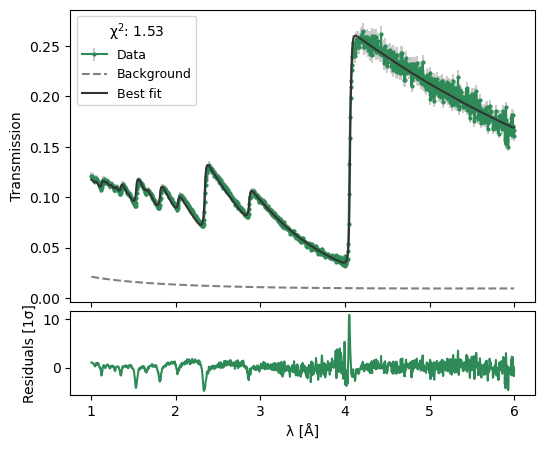

In [2]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")            # read data
xs = nbragg.CrossSection(iron="Fe_sg229_Iron-alpha.ncmat")                      # define sample
model = nbragg.TransmissionModel(xs, vary_background=True, vary_response=True)   # define model
result = model.fit(data)                                                         # perform fit
result.plot();                                                                   # plot results

In [3]:
result.params  # Inspect fitted parameters

name,value,standard error,relative error,initial value,min,max,vary
thickness,1.97199136,0.02039813,(1.03%),1.0,0.00000000,5.00000000,True
norm,0.78302522,0.00980495,(1.25%),1.0,0.10000000,10.0000000,True
temp,300.000000,0.00000000,(0.00%),300.0,77.0000000,1000.00000,False
α0,2.58214147,0.06915169,(2.68%),3.67,1.0000e-03,10000.0000,True
β0,3.82880800,0.12729557,(3.32%),3.06,1.0000e-03,10000.0000,True
bg0,-0.02222263,0.00722110,(32.49%),0.0,-1000000.00,1000000.00,True
bg1,0.00686979,0.00222015,(32.32%),0.0,-1000000.00,1000000.00,True
bg2,0.03647042,0.00512633,(14.06%),0.0,-1000000.00,1000000.00,True


# Load data
Use the `nbragg.Data` object to read Bragg-edge data from CSV.

In [4]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")

The data is available as a table via `data.table`. Use `data.plot()` for a quick look.

In [5]:
data.table

,wavelength,trans,err
0,0.501098,0.148315,0.004449
1,0.505493,0.147728,0.004432
2,0.509889,0.147725,0.004432
3,0.514284,0.148043,0.004441
4,0.518680,0.148369,0.004451
...,...,...,...
2156,9.977258,0.050633,0.001519
2157,9.982328,0.043011,0.001291
2158,9.986135,0.103448,0.003104
2159,9.991219,0.062500,0.001875


<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

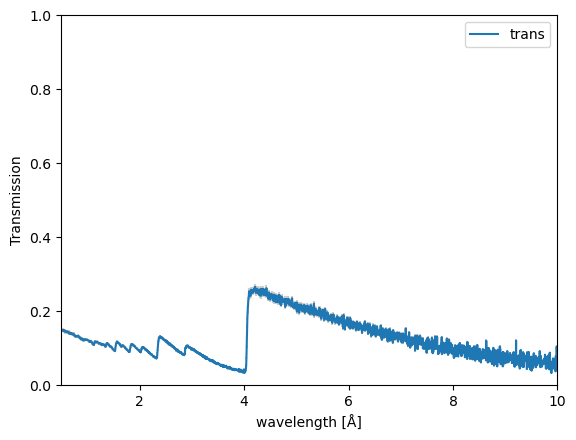

In [7]:
data.plot()

## Define samples
Define the composition of the sample. You can choose predefined crystalline materials from the **NCrystal** standard library, available under the `nbragg.materials` dictionary.

In [8]:
nbragg.materials["AgBr_sg225_SilverBromide.ncmat"]

{'name': 'SilverBromide',
 'mat': 'AgBr_sg225_SilverBromide.ncmat',
 'formula': 'AgBr',
 'space_group': 'sg225'}

Use the `nbragg.CrossSection` method to load a single material from the library.

In [9]:
gamma = nbragg.CrossSection(gamma=nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

You can also register new `.ncmat` files into the NCrystal library using `nbragg.utils.register_material`, then access them from `nbragg.materials` the same way.

In [10]:
nbragg.utils.register_material("Fe_sg229_Iron-alpha_LGS.ncmat")
alphaLGS = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"])

You can combine materials by simple addition. The `cfg_string` will use NCrystal's `phases` syntax to define a multiphase material. Optional weights can be provided by scaling each component.

In [11]:
xs = alpha + gamma

# or with weights
xs = alpha*0.3 + gamma*0.7

In [12]:
xs.cfg_string

'phases<0.3*Fe_sg229_Iron-alpha.nbragg;temp=300.0K&0.7*Fe_sg225_Iron-gamma.nbragg;temp=300.0K>'

Access the cross-section data via `xs.table` and plot with `xs.plot()`.

In [13]:
xs.table

,alpha,gamma,total
wavelength,,,
1.00,12.296487,12.429806,12.388762
1.01,12.417385,12.512904,12.483497
1.02,12.418585,12.445530,12.437235
1.03,12.542142,12.210174,12.312376
1.04,12.668032,12.290402,12.406661
...,...,...,...
9.95,15.323228,15.549098,15.479560
9.96,15.338098,15.564084,15.494511
9.97,15.352966,15.579069,15.509460


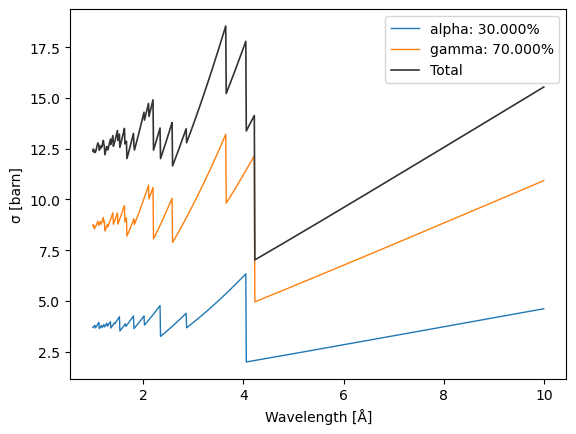

In [14]:
xs.plot();

# Define a transmission model
The fit process in **nbragg** uses the friendly `lmfit` parameter framework.

Construct a `TransmissionModel` from a `CrossSection`, and enable optional model components via flags. Here we vary background, instrument response, and time-of-flight parameters.

In [15]:
model = nbragg.TransmissionModel(alpha, background="polynomial3", vary_background=True, vary_response=True, vary_tof=True)

In [16]:
model.params  # Inspect default parameter set

name,value,initial value,min,max,vary
thickness,1.00000000,1.0,0.00000000,5.00000000,True
norm,1.00000000,1.0,0.10000000,10.0000000,True
temp,300.000000,300.0,77.0000000,1000.00000,False
L0,1.00000000,1.0,0.50000000,1.50000000,True
t0,0.00000000,0.0,-5.0000e-06,5000000.00,True
α0,3.67000000,3.67,1.0000e-03,10000.0000,True
β0,3.06000000,3.06,1.0000e-03,10000.0000,True
bg0,0.00000000,0.0,-1000000.00,1000000.00,True
bg1,0.00000000,0.0,-1000000.00,1000000.00,True
bg2,0.00000000,0.0,-1000000.00,1000000.00,True


# Fit
After adjusting parameters (optional), call `model.fit` to perform the fit over a chosen wavelength window.

In [17]:
result = model.fit(data, wlmin=1, wlmax=5)

Fitting:   0%|          | 0/1 [00:00<?, ?it/s]

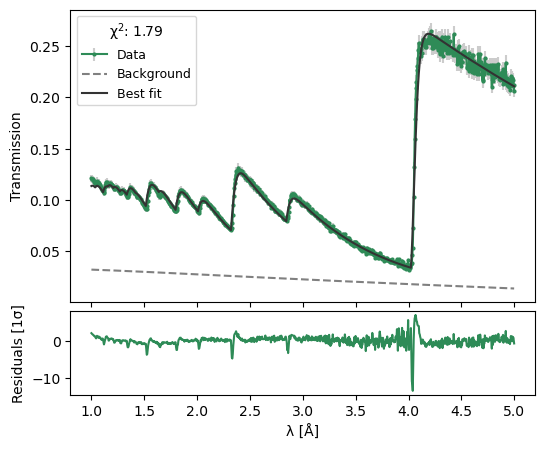

In [18]:
result.plot();

In [19]:
result  # Summary including chi2, parameter values, and uncertainties

# Oriented materials

You can load **oriented** materials by specifying crystal directions relative to the beam axis.

- `dir1`: a crystal direction aligned relative to the beam (assumed z-axis).
- `dir2`: a second crystal direction relative to the y-axis.
- `theta` and `phi`: additional rotations around z and y axes (degrees).
- `mos`: mosaicity (degrees) for each phase.

Below is an example multiphase oriented material.

In [20]:
nbragg.materials["Be_sg194.ncmat"]

{'name': 'Be',
 'mat': 'Be_sg194.ncmat',
 'formula': 'Be',
 'space_group': 'sg194'}

In [21]:
gamma =     {
            "mat": "Fe_sg225_Iron-gamma.ncmat",
            "temp": 300,
            "weight": 0.3
            }
beryllium = {
            "mat": "Be_sg194.ncmat",
            "temp": 300,
            "mos": 3,
            "dir1": [0, 0, 1],
            "dir2": [1, 0, 0],
            "theta": 10.0,
            "phi": 10.0,
            "weight": 0.7,
            "dirtol": 30
            }
xs2 = nbragg.CrossSection(gamma=gamma, beryllium=beryllium)

In [22]:
xs2.materials  # Inspect phase definitions

{'gamma': {'mat': 'Fe_sg225_Iron-gamma.ncmat',
  'temp': 300,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_tilt': None,
  'weight': 0.3},
 'beryllium': {'mat': 'Be_sg194.ncmat',
  'temp': 300,
  'mos': 3,
  'dir1': [0, 0, 1],
  'dir2': [1, 0, 0],
  'dirtol': 30,
  'theta': 10.0,
  'phi': 10.0,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_tilt': None,
  'weight': 0.7}}

The configuration string reflects the oriented phases and parameters.

In [23]:
xs2.cfg_string

'phases<0.7*Be_sg194.nbragg;dir1=@crys_hkl:0.17364818,0.00000000,0.98480775@lab:0,0,1;dir2=@crys_hkl:0.96984631,0.17364818,-0.17101007@lab:0,1,0;dirtol=30deg;mos=3deg;temp=300K&0.3*Fe_sg225_Iron-gamma.nbragg;temp=300K>'

<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

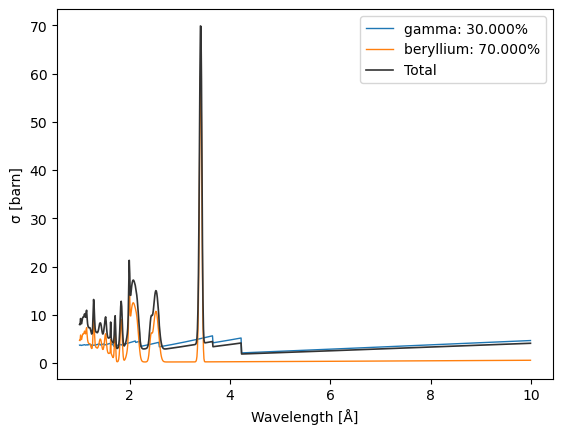

In [24]:
xs2.plot()

Oriented materials can be combined with other (oriented/non-oriented) materials using the same syntax as before.

In [25]:
xs3 = xs2*0.2 + xs*0.8

In [26]:
xs3.phases  # Combined phases

{'alpha': 'Fe_sg229_Iron-alpha.nbragg;temp=300.0K',
 'beryllium': 'Be_sg194.nbragg;dir1=@crys_hkl:0.17364818,0.00000000,0.98480775@lab:0,0,1;dir2=@crys_hkl:0.96984631,0.17364818,-0.17101007@lab:0,1,0;dirtol=30deg;mos=3deg;temp=300K',
 'gamma': 'Fe_sg225_Iron-gamma.nbragg;temp=300K',
 'gamma_1': 'Fe_sg225_Iron-gamma.nbragg;temp=300.0K'}

<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

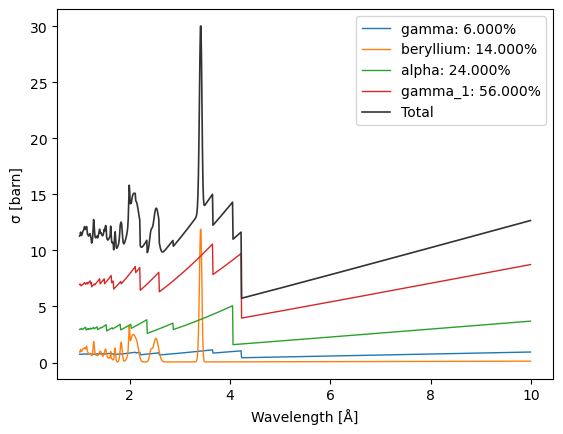

In [27]:
xs3.plot()

# MTEX integration
MTEX (MATLAB) can analyze diffraction peaks to infer phase fractions and textures; those can seed the Bragg-edge model in **nbragg**.

Use the MATLAB scripts in the repository (`mtex_scripts/`) to export predicted phase weights, directions, and mosaicities to CSV. See the **mtex integration README** for details.

The scripts output a CSV with phase weights, orientation vectors, and mosaicity. You can load this with `nbragg.CrossSection.from_mtex` to create a multiphase `CrossSection`.

In [28]:
xs_alpha = nbragg.CrossSection.from_mtex(
    "sf_alpha_ncrystal.csv",
    nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"],
    short_name="α",
)

xs_gamma = nbragg.CrossSection.from_mtex(
    "sf_gamma_ncrystal.csv",
    nbragg.materials["Fe_sg225_Iron-gamma_LGS.ncmat"],
    short_name="γ",
)

In [29]:
xs_gamma.materials  # Inspect the phases imported from MTEX

{'γ0': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300,
  'mos': np.float64(18.587635),
  'dir1': [0.6441900482655264, -0.42660643576314217, 0.6348433906729493],
  'dir2': [0.5657658668405976, 0.8243193609334006, -0.02016370770610611],
  'dirtol': 1.0,
  'theta': 0.0,
  'phi': 0.0,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_tilt': None,
  'weight': 0.25650124},
 'γ1': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300,
  'mos': np.float64(20.339102),
  'dir1': [0.854099240380397, 0.5090663732331492, -0.10661104644865317],
  'dir2': [-0.512933562842995, 0.8583625620276916, -0.010624133774035573],
  'dirtol': 1.0,
  'theta': 0.0,
  'phi': 0.0,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_tilt': None,
  'weight': 0.16803913},
 'γ2': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300,
  'mos': np.float64(9.052248),
  'dir1': 

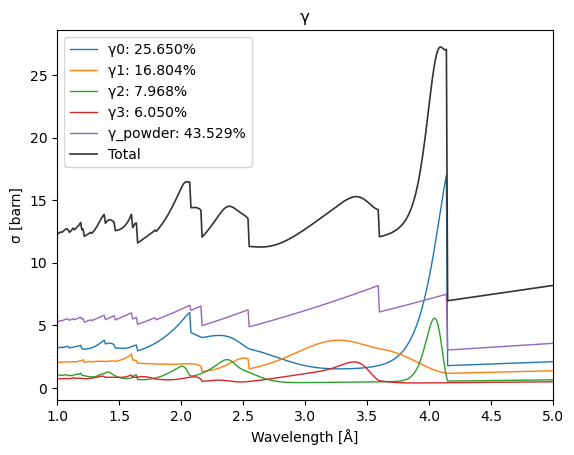

In [30]:
xs_gamma.plot(xlim=(1, 5));

# Fitting Large-Grain Steel Data


We'll use the MTEX-generated materials to fit a multiphase large-grain steel sample.

## Load data
Use `nbragg.Data.from_counts(signal_csv, openbeam_csv)` with two CSV files: the sample **signal** and the **open-beam** reference.

Each CSV should have three columns:
- **slice**: Identifier for each slice of the sample,
- **counts**: Measured counts for each slice,
- **error**: Measurement error associated with each count value.

In [31]:
data = nbragg.Data.from_counts("large_grain_steel_0deg.csv", "openbeam.csv")

<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

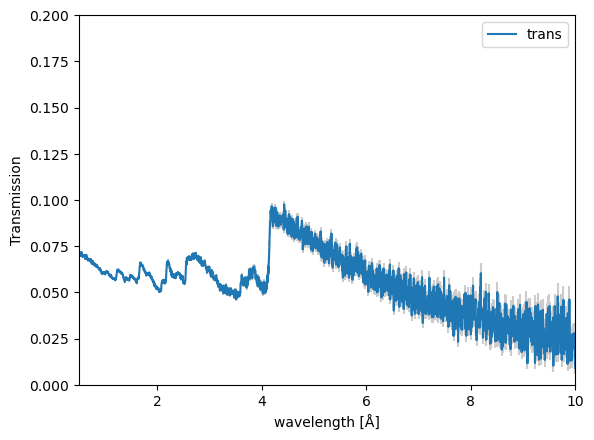

In [32]:
data.plot(ylim=(0, 0.2))

Define a model based on the MTEX-derived **iron-gamma** cross section.

In [33]:
model = nbragg.TransmissionModel(xs_gamma, vary_background=True, vary_weights=True)

In [34]:
model.params["norm"].value = 1.0/2.3
model.params["thickness"].value = 1.27
model.params["thickness"].vary = True
model.params  # Review current parameters

name,value,initial value,min,max,vary,expression
thickness,1.27000000,1.0,0.00000000,5.00000000,True,
norm,0.43478261,1.0,0.10000000,10.0000000,True,
temp,300.000000,300,77.0000000,1000.00000,False,
p1,-0.52887420,-0.5288741982897172,-14.0000000,14.0000000,True,
p2,-0.95181083,-0.9518108282477983,-14.0000000,14.0000000,True,
p3,-1.69803590,-1.6980358972652292,-14.0000000,14.0000000,True,
p4,-1.97343971,-1.9734397069014835,-14.0000000,14.0000000,True,
γ0,0.25650124,None,-inf,inf,False,exp(p1) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))
γ1,0.16803913,None,-inf,inf,False,exp(p2) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))
γ2,0.07967627,None,-inf,inf,False,exp(p3) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))


In [35]:
result = model.fit(data, wlmin=2, wlmax=5)

Fitting:   0%|          | 0/1 [00:00<?, ?it/s]

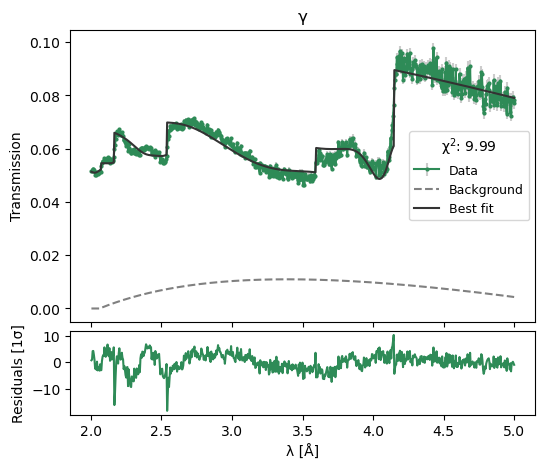

In [36]:
result.plot();

In [37]:
result

Now we also vary the **orientation**.

In [40]:
model = nbragg.TransmissionModel(
    xs_gamma,
    vary_background=True,
    vary_weights=True,
    vary_orientation=True,
)
# Example: reuse previous best params (optional)
model.update_params(result.params)
model.params["thickness"].vary = False
model.params["norm"].vary = False
model.params["θ2"].vary = False
model.params["θ3"].vary = False
model.params["θ4"].vary = False
model.params["ϕ2"].vary = False
model.params["ϕ3"].vary = False
model.params["ϕ4"].vary = False
model.params

name,value,initial value,min,max,vary
thickness,0.73377329,0.733773287046384,0.00000000,5.00000000,False
norm,0.12600559,0.12600558505503148,0.10000000,10.0000000,False
temp,300.000000,300,77.0000000,1000.00000,False
p1,-13.9023747,-13.902374698160205,-14.0000000,14.0000000,True
p2,-0.88518442,-0.8851844158795377,-14.0000000,14.0000000,True
p3,-2.18041513,-2.1804151283441158,-14.0000000,14.0000000,True
p4,-6.29375761,-6.293757609766772,-14.0000000,14.0000000,True
γ0,6.0020e-07,6.0020478266697e-07,-inf,inf,False
γ1,0.27014278,0.27014277775956214,-inf,inf,False
γ2,0.07397446,0.07397446109375698,-inf,inf,False


In [41]:
result2 = model.fit(data, wlmin=2, wlmax=5)

Fitting:   0%|          | 0/1 [00:00<?, ?it/s]

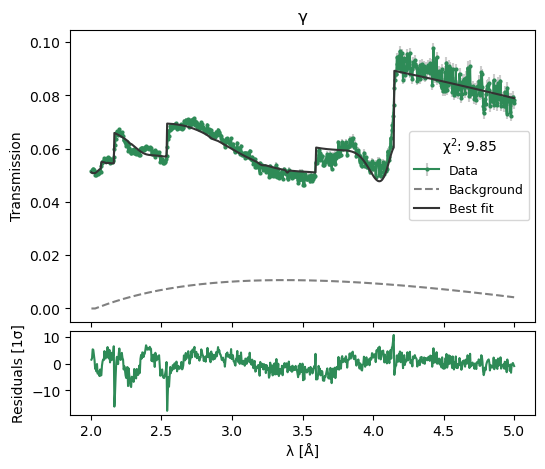

In [42]:
result2.plot();